In [8]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 10
maxUnits = 50
stepsUnits = 10
defaultUnits = 30

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 40
executions = 2

# Epochs
epchs = 100

TF version: 2.15.0
KT version: 1.0.5
Panda version: 2.2.0
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Please install GPU version of TF
Num GPUs Available:  0
Build with CUDA:  False


C:\Users\hecto\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
df = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W20_H20.csv",
                delimiter=";")

dfTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W20_H20.csv",
                delimiter=";")

# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W7.csv",
#                        delimiter=",")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W7.csv",
#                    delimiter=",")

# projectNameBO = "W7_PV-lstm-bo"
# projectNameRS = "W7_PV-lstm-rs"

# projectNameRS = "PV_W140_H20-lstm-rs"
# projectNameBO = "PV_W140_H20-lstm-bo"

projectNameRS = "CPU-PV_W20_H20-lstm-rs"
projectNameBO = "CPU-PV_W20_H20-lstm-bo"

W=20
H=20



In [10]:
# Preprocessing for PV_W_H type files:

df = df.replace(',', '.', regex=True)
dfTest = dfTest.replace(',', '.', regex=True)

#  Uncomment in order to normalize data
# Data Normalization

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# Filter for PV data
X = df.iloc[:, 0:W]
xTest = dfTest.iloc[:, 0:W]

Y = df.iloc[:, W:]
yTest = dfTest.iloc[:, W:]

numPredictions = H

print(X)
print(yTest)



           0         1         2         3         4         5         6   \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
359  0.774161  0.837234  0.787854  0.887529  0.847939  0.857222  0.794488   
360  0.411077  0.462226  0.514200  0.685503  0.523645  0.316204  0.170055   
361  0.613180  0.626831  0.694342  0.648561  0.577754  0.532984  0.800992   
362  0.409110  0.744482  0.751825  0.512533  0.366450  0.402183  0.587833   
363  0.767228  0.837637  0.778665  0.884541  0.532391  0.673598  0.770680   

           7         8         9         10        11        12        13  

In [11]:


# numPredictions = H

# df = df.replace(',', '.', regex=True)
# dfTest = dfTest.replace(',', '.', regex=True)

# # Data normalization
# scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df))
# dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# # Merge the two data sources
# X = pd.concat([X, df], axis = 1)
# xTest = pd.concat([xTest, dfTest], axis = 1)

# print("Source shape: ", X.shape)

# # NaN treatment
# if W == 1:
#     X.drop(X.tail(W).index, inplace = True)
#     xTest.drop(xTest.tail(W).index, inplace = True)
# else :
#     X.drop(X.tail(W-1).index, inplace = True)
#     xTest.drop(xTest.tail(W-1).index, inplace = True)


# # Y will contain only the last H columns, the data from the following day
# Y = X.iloc[:, -H:]
# yTest = xTest.iloc[:, -H:]

# # X will contain the rest of the data
# X = X.iloc[:, :-H]
# xTest = xTest.iloc[:, :-H]


# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")




In [12]:
# #  Old ---- W type data preprocessing:

# # Y will be the next day pv data, aka the last column from the next row.
# shifted_df = X.shift(-1)
# Y = pd.DataFrame(shifted_df.iloc[:, -1])

# shifted_df = xTest.shift(-1)
# yTest = pd.DataFrame(shifted_df.iloc[:, -1])

# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# xTest.drop(xTest.tail(1).index, inplace = True)
# yTest.drop(yTest.tail(1).index, inplace = True)

# numPredictions = 1

In [13]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], 1, xTrain.shape[1]))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], 1, yTrain.shape[1]))
xval = np.reshape(xVal.values, (xVal.shape[0], 1,  xVal.shape[1]))
yval = np.reshape(yVal.values, (yVal.shape[0], 1, yVal.shape[1]))
xtest = np.reshape(xTest.values, (xTest.shape[0], 1, xTest.shape[1]))
ytest = np.reshape(yTest.values, (yTest.shape[0], 1, yTest.shape[1]))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

DataFrame Preproccessed:
           0         1         2         3         4         5         6   \
0    0.202547  0.343202  1.000000  0.842291  0.577134  0.745918  0.996233   
1    0.426514  0.294835  0.574558  0.485647  0.827078  0.838485  0.959061   
2    0.230347  0.267902  0.116575  0.189409  0.229192  0.324692  0.254022   
3    0.815427  0.732371  0.665736  0.544064  0.661029  0.580754  0.651991   
4    0.586870  0.752408  0.486835  0.536889  0.585460  0.500163  0.220289   
..        ...       ...       ...       ...       ...       ...       ...   
359  0.774161  0.837234  0.787854  0.887529  0.847939  0.857222  0.794488   
360  0.411077  0.462226  0.514200  0.685503  0.523645  0.316204  0.170055   
361  0.613180  0.626831  0.694342  0.648561  0.577754  0.532984  0.800992   
362  0.409110  0.744482  0.751825  0.512533  0.366450  0.402183  0.587833   
363  0.767228  0.837637  0.778665  0.884541  0.532391  0.673598  0.770680   

           7         8         9   ...        30  

In [14]:
# Model definition:
# with tf.device('/gpu:0'): 
    
def build_model(hp): 

    model = Sequential()
    
    # model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
    # First layer: LSTM. Number of units optimization
    model.add(LSTM(units = hp.Int('units', 
                                min_value = minUnits,
                                max_value = maxUnits, 
                                step = stepsUnits,
                                default = defaultUnits),
                    return_sequences = True, 
                    input_shape = (xtrain.shape[1], xtrain.shape[2])))

    # Second layer: Dropout with percetange optimization
    model.add(
        Dropout(hp.Float('dropout', 
                        min_value = minDropout,
                        max_value = maxDropout,
                        default = defaultDropout)))
    
    # Last layer:
    model.add(Dense(numPredictions))

    #print("Summary: ")
    #model.summary()

    # Model compilation: learning rate optimization
    model.compile(loss = loss,
                optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                            values = learningRate)),
                metrics = modelMetrics)

    return model

In [15]:
# Model training:
# with tf.device('/gpu:0'): 
# Create optimizer using Random Search
lstmOptimizer = RandomSearch(build_model, 
                            objective = objective,
                            max_trials = trials, 
                            executions_per_trial = executions,
                            project_name = projectNameRS,
                            overwrite = True)

# Search space summary
#lstmOptimizer.search_space_summary()

# Search execution with epochs
initialTime = time.time()
lstmOptimizer.search(x = xtrain,
                    y = ytrain, 
                    epochs = epchs,
                    batch_size = batch,
                    validation_data = (xval, yval),
                    verbose = 1)
finalTime = time.time()

# Get best model generated
model = lstmOptimizer.get_best_models(num_models = numBestModels)[0]

# Model training with epochs 
history = model.fit(
            xtrain,
            ytrain,
            epochs = epchs,
            batch_size = batch,
            validation_data = (xval, yval))

# Show model info

print(history.history.keys())
print(model.history.history)
print(model.history.params)

Trial 40 Complete [00h 00m 13s]
val_mean_absolute_error: 0.6188203990459442

Best val_mean_absolute_error So Far: 0.20578932017087936
Total elapsed time: 00h 08m 56s

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.1738 - mean_absolute_error: 0.1738 - rmse: 0.3988 - val_loss: 0.2106 - val_mean_absolute_error: 0.2106 - val_rmse: 0.2683
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.1636 - mean_absolute_error: 0.1636 - rmse: 0.2103 - val_loss: 0.2219 - val_mean_absolute_error: 0.2219 - val_rmse: 0.2741
Epoch 3/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1640 - mean_absolute_error: 0.1640 - rmse: 0.2100 - val_loss: 0.2354 - val_mean_absolute_error: 0.2354 - val_rmse: 0.2837
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1611 - mean_absolute_error: 0.1611 - rmse: 0.2066 - val_loss: 0.2479 - val_mean_absolute_error: 0.2479 - val_rmse: 0.2940
Epoch 5/100
1/1 [==============================] - 

------------------------------------------------------
SUMMARY
------------------------------------------------------
Tiempo de entrenamiento (en segundos):	535.8909754753113


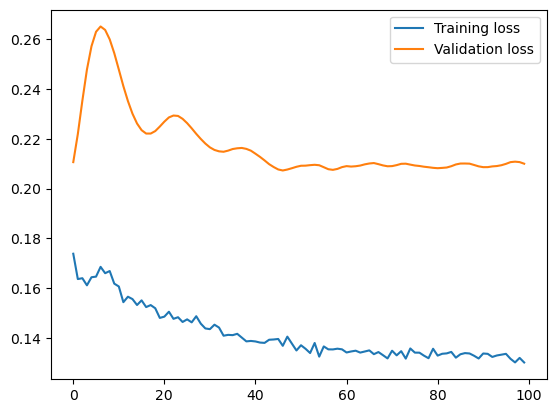

Results summary
Results in .\CPU-PV_W20_H20-lstm-rs
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 28 summary
Hyperparameters:
units: 20
dropout: 0.06055312055747043
learning_rate: 0.01
Score: 0.20578932017087936
12/12 [==============================] - 0s 1ms/step - loss: 0.1588 - mean_absolute_error: 0.1588 - rmse: 0.2112
Score: [0.158821240067482, 0.158821240067482, 0.21118435263633728]


In [16]:
# Model evaluation:
print("------------------------------------------------------")
print("SUMMARY")
print("------------------------------------------------------")

print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Results summary
lstmOptimizer.results_summary(num_trials = 1)

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)


In [17]:
# Model training:
# with tf.device('/gpu:0'): 
# Create optimizer using Bayesian Optimization
lstmOptimizerBO = BayesianOptimization(build_model, 
                            objective = objective,
                            max_trials = trials, 
                            executions_per_trial = executions,
                            project_name = projectNameBO,
                            overwrite = True)

# Search space summary
#lstmOptimizer.search_space_summary()

# Search execution with epochs
initialTime = time.time()
lstmOptimizerBO.search(x = xtrain,
                    y = ytrain, 
                    epochs = epchs,
                    batch_size = batch,
                    validation_data = (xval, yval),
                    verbose = 1)
finalTime = time.time()

# Get best model generated
model = lstmOptimizerBO.get_best_models(num_models = numBestModels)[0]

# Model training with epochs 
history = model.fit(
            xtrain,
            ytrain,
            epochs = epchs,
            batch_size = batch,
            validation_data = (xval, yval))

# Show model info

print(history.history.keys())
print(model.history.history)
print(model.history.params)

Trial 40 Complete [00h 00m 17s]
val_mean_absolute_error: 0.22667532414197922

Best val_mean_absolute_error So Far: 0.20467083156108856
Total elapsed time: 00h 10m 16s
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.1304 - mean_absolute_error: 0.1304 - rmse: 0.2141 - val_loss: 0.2047 - val_mean_absolute_error: 0.2047 - val_rmse: 0.2597
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1302 - mean_absolute_error: 0.1302 - rmse: 0.1789 - val_loss: 0.2053 - val_mean_absolute_error: 0.2053 - val_rmse: 0.2601
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1300 - mean_absolute_error: 0.1300 - rmse: 0.1786 - val_loss: 0.2060 - val_mean_absolute_error: 0.2060 - val_rmse: 0.2603
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1298 - mean_absolute_error: 0.1298 - rmse: 0.1782 - val_loss: 0.2063 - val_mean_absolute_error: 0.2063 - val_rmse: 0.2601
Epoch 5/100
1/1 [==============================] - 

------------------------------------------------------
SUMMARY BO
------------------------------------------------------
Tiempo de entrenamiento (en segundos):	615.5808296203613


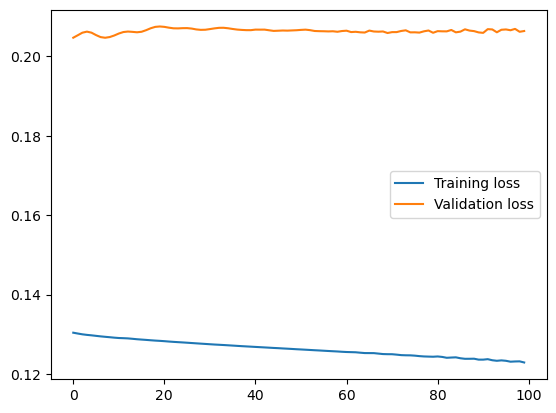

Results summary
Results in .\CPU-PV_W20_H20-lstm-bo
Showing 1 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 31 summary
Hyperparameters:
units: 40
dropout: 0.0
learning_rate: 0.01
Score: 0.20467083156108856
12/12 [==============================] - 0s 1ms/step - loss: 0.1579 - mean_absolute_error: 0.1579 - rmse: 0.2148
Score: [0.15794414281845093, 0.15794414281845093, 0.21475815773010254]


In [18]:
# Model evaluation:
print("------------------------------------------------------")
print("SUMMARY BO")
print("------------------------------------------------------")

print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Results summary
lstmOptimizerBO.results_summary(num_trials = 1)

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)